# Решение задачи

Прежде чем что-то обновлять, надо проверить текущую версию. Нам необходима версия Keras 3.0 или выше. Существует простой способ проверки версии библиотеки Keras:

In [ ]:
import keras

print(keras.__version__)

3.8.0


Импортируем необходимые библиотеки, обозначим размерность и будем использовать технику `mixed precision` (смешанной точности) для ускорения вычислений на *GPU*:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random
import numpy as np
from tensorflow.keras import mixed_precision

#ускорение GPU
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

Далее нам потребуется скачать датасет, с которым будет происходить дальнейшая работа:

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2025-05-16 18:06:06--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  15.1MB/s    in 53s     

2025-05-16 18:07:01 (13.9 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



Затем распакуем архив с датасетом:

In [ ]:
#разархивируем датасета в папку 'dataset'
!unzip -qo "stanford_dogs" -d ./dataset

#папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

Теперь необходимо отфильтровать плохо закодированные изображения, в заголовке которых отсутствует строка "JFIF". JPEG и JPG картинки всегда содержат строку "JFIF". Если строка отсутствует файл "битый", либо другого формата.

In [ ]:
num_skipped = 0 #счётчик повреждённых файлов
for folder_name in os.listdir(IMAGE_PATH): #перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) #склеиваем путь
    for fname in os.listdir(folder_path): #получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) #получаем путь до файла
        try:
            fobj = open(fpath, "rb") #пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) #получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() #закрываем файл

        if not is_jfif: #если не нашли JFIF строку
            num_skipped += 1 #увеличиваем счётчик
            os.remove(fpath) #удаляем повреждённое изображение

print(f"Удалено повреждённых изображений с датасета: {num_skipped}")

Удалено повреждённых изображений с датасета: 10


Сгенерируем датасет, используя метод `image_dataset_from_directory`:

In [ ]:
#создаем train и временный temp_val_ds (потом разделим на val_ds и test_ds)
train_ds, temp_val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.2, #20% для val+test
    subset="both", #получаем train и остаток (val+test)
    seed=42,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


Разделяем временный `temp_val_ds` на *val* и *test* (50/50):

In [ ]:
val_size = int(0.5 * len(temp_val_ds))
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

Определим метки датасета и выведем их:

In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))  #определяем список имён классов
CLASS_COUNT = len(CLASS_LIST)  #определяем количества классов

print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

Несмотря, на то, что наш датасет содержит 20570 изображений (с учетом "битых" файлов), но в пересчете на одну категорию получается примерно по 171 изображению на каждую категорию. Это совсем небольшой датасет, и потому хорошей практикой считается проведение аугментации (или расширения данных):

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.1), #вращаем изображение
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05), #сдвиг по вертикали и горизонтали
    layers.RandomFlip(), #отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.05), #изменяем контрастность
]

def img_augmentation(images):
    #слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Применим функцию `img_augmentation` к обучающей выборке и **one-hot кодирование меток** ко всем выборкам. Также используется `AUTOTUNE`, который автоматически выбирает оптимальное число потоков для параллельной обработки (ускоряет загрузку данных). Аугментацию будем применять только к обучающей выборке.

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE
)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

Создадим функцию для вывода 2 графиков, а именно: **"График точности на обучающей и проверочной выборках"** и "**График потерь на обучающей и проверочной выборках"**:

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

Далее мы инициализируем модель с предварительно обученными весами **ImageNet** и с помощью тонкой настройки (**fine-tune**) настраиваем ее на нашем собственном наборе данных. В качестве архитектуры глубокого изучения будем использовать **EfficientNetV2**.

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False #заморозка предобученных весов

    #замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2) #указываем какой будет оптимизатор
    #компилируем модель
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

Перейдем к финальной стадии - обучение модели. Будем использовать 3 **callbacks**, а именно: **ModelCheckpoint**, **EarlyStopping** и **ReduceLROnPlateau**:

In [ ]:
epochs = 20

early_stopping_stage1 = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_stage1 = ModelCheckpoint(
    filepath="best_model_stage1.keras",
    monitor="val_acc",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr_stage1 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-4,
    verbose=1
)

model = build_model(num_classes=CLASS_COUNT)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping_stage1, model_checkpoint_stage1, reduce_lr_stage1])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3218 - loss: 3.8012
Epoch 1: val_acc improved from -inf to 0.79688, saving model to best_model_stage1.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - acc: 0.3228 - loss: 3.7948 - val_acc: 0.7969 - val_loss: 0.6718 - learning_rate: 0.0100
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.5994 - loss: 1.7831
Epoch 2: val_acc improved from 0.79688 to 0.82764, saving model to best_model_stage1.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - acc: 0.5995 - loss: 1.7818 - val_acc: 0.8276 - val_loss: 0.5372 - learning_rate: 0.0100
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.6598 - loss: 1.2333
Epoch 3: val_acc improved from 0.82764 to 0.84912, saving model to best_model_stage1.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - acc: 0.6598 - loss: 1.2331 - val_acc: 0.8491 - val_loss: 0.4707 - learning_rate: 0.0100
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 

После выполнения обучения воспользуемся раннее созданной функцией для вывода графиков:

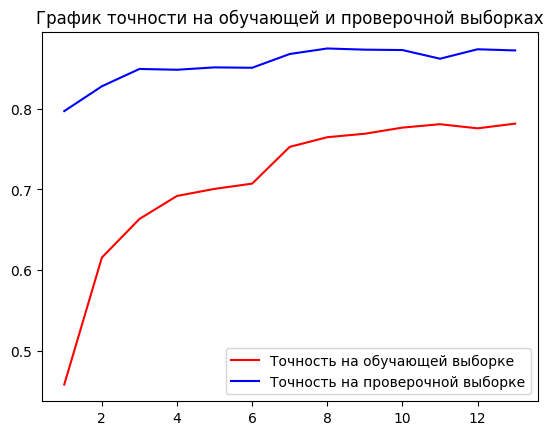

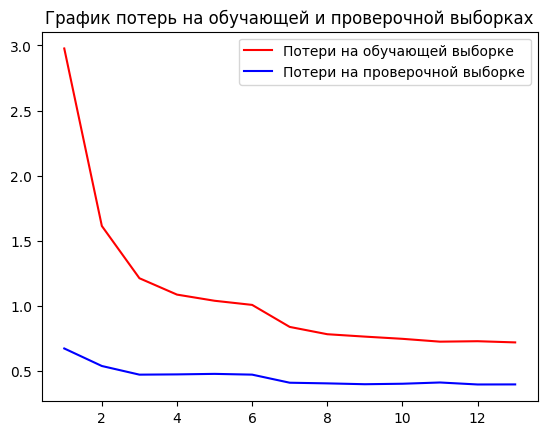

In [ ]:
show_plot(history)

Хорошей практикой будет сохранение модели:

In [ ]:
from google.colab import files
files.download('best_model_stage1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь выполним тонкую настройку (**fine-tuning**) модели.

`model.layers[-50:]` — выбирает 50 верхних слоёв модели (ближайших к выходу).

`if not isinstance(layer, BatchNormalization)` — пропускает слои **BatchNormalization**, чтобы не нарушить их статистику (они обычно остаются замороженными при **fine-tuning**).

`layer.trainable = True` — размораживает выбранные слои для обучения.

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7696 - loss: 0.7533
Epoch 1: val_acc improved from -inf to 0.87207, saving model to best_model_stage2.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - acc: 0.7697 - loss: 0.7532 - val_acc: 0.8721 - val_loss: 0.4011 - learning_rate: 1.0000e-05
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7700 - loss: 0.7508
Epoch 2: val_acc improved from 0.87207 to 0.87256, saving model to best_model_stage2.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - acc: 0.7701 - loss: 0.7505 - val_acc: 0.8726 - val_loss: 0.4017 - learning_rate: 1.0000e-05
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7840 - loss: 0.7040
Epoch 3: val_acc improved from 0.87256 to 0.87305, saving model to best_model_stage2.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - acc: 0.7841 - loss: 0.7039 - val_acc: 0.8730 - val_loss: 0.4014 - learning_rate: 1.0000e-05
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.7845 - loss: 0.7223
Ep

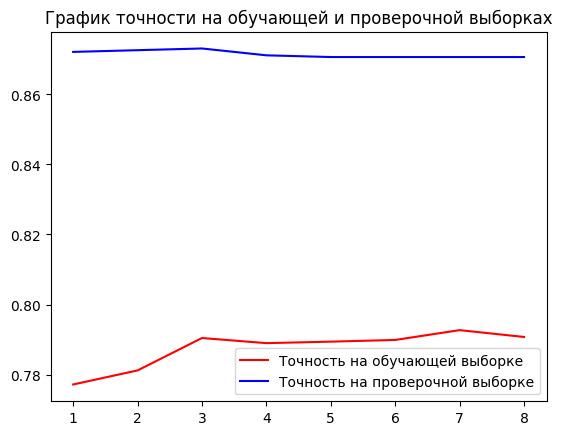

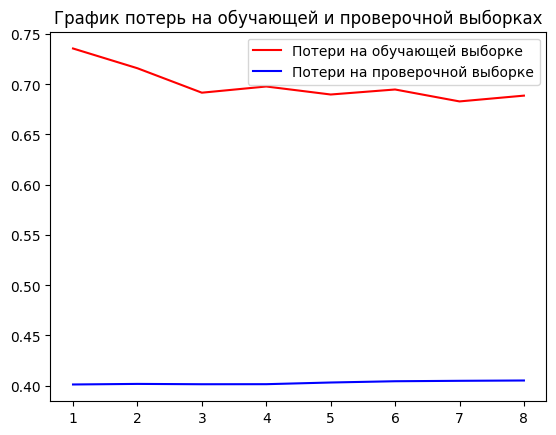

In [ ]:
def unfreeze_model(model):
    #размораживаем 50 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-50:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )

unfreeze_model(model)

early_stopping_stage2 = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_stage2 = ModelCheckpoint(
    filepath="best_model_stage2.keras",
    monitor="val_acc",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr_stage2 = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.1,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

epochs = 10

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping_stage2, model_checkpoint_stage2, reduce_lr_stage2])

show_plot(history)

Так же сохраняем модель после финального обучения:

In [ ]:
files.download('best_model_stage2.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Теперь можно узнать точности на всех наших трёх выборках, а именно: обучающая, валидационная и тестовая

In [ ]:
#вывод точности после дообучения
final_train_acc_finetune = history.history['acc'][-1]
final_val_acc_finetune = history.history['val_acc'][-1]
print(f"\nФинальная точность после дообучения:")
print(f"Обучающая выборка: {final_train_acc_finetune:.4f}")
print(f"Валидационная выборка: {final_val_acc_finetune:.4f}")

#оценка на тестовой выборке
print("\nОценка на тестовой выборке:")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")


Финальная точность после дообучения:
Обучающая выборка: 0.7908
Валидационная выборка: 0.8706

Оценка на тестовой выборке:
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 603ms/step - acc: 0.8555 - loss: 0.4770
Test accuracy: 0.8664


Случайным образом отобразим 10 пород собак, выполним аугментацию и выполним предсказание:

Выбранные 10 пород собак:
1. Rhodesian_ridgeback
2. Boston_bull
3. Mexican_hairless
4. Borzoi
5. Pug
6. Groenendael
7. Irish_terrier
8. Standard_schnauzer
9. coated_wheaten_terrier
10. Airedale
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step


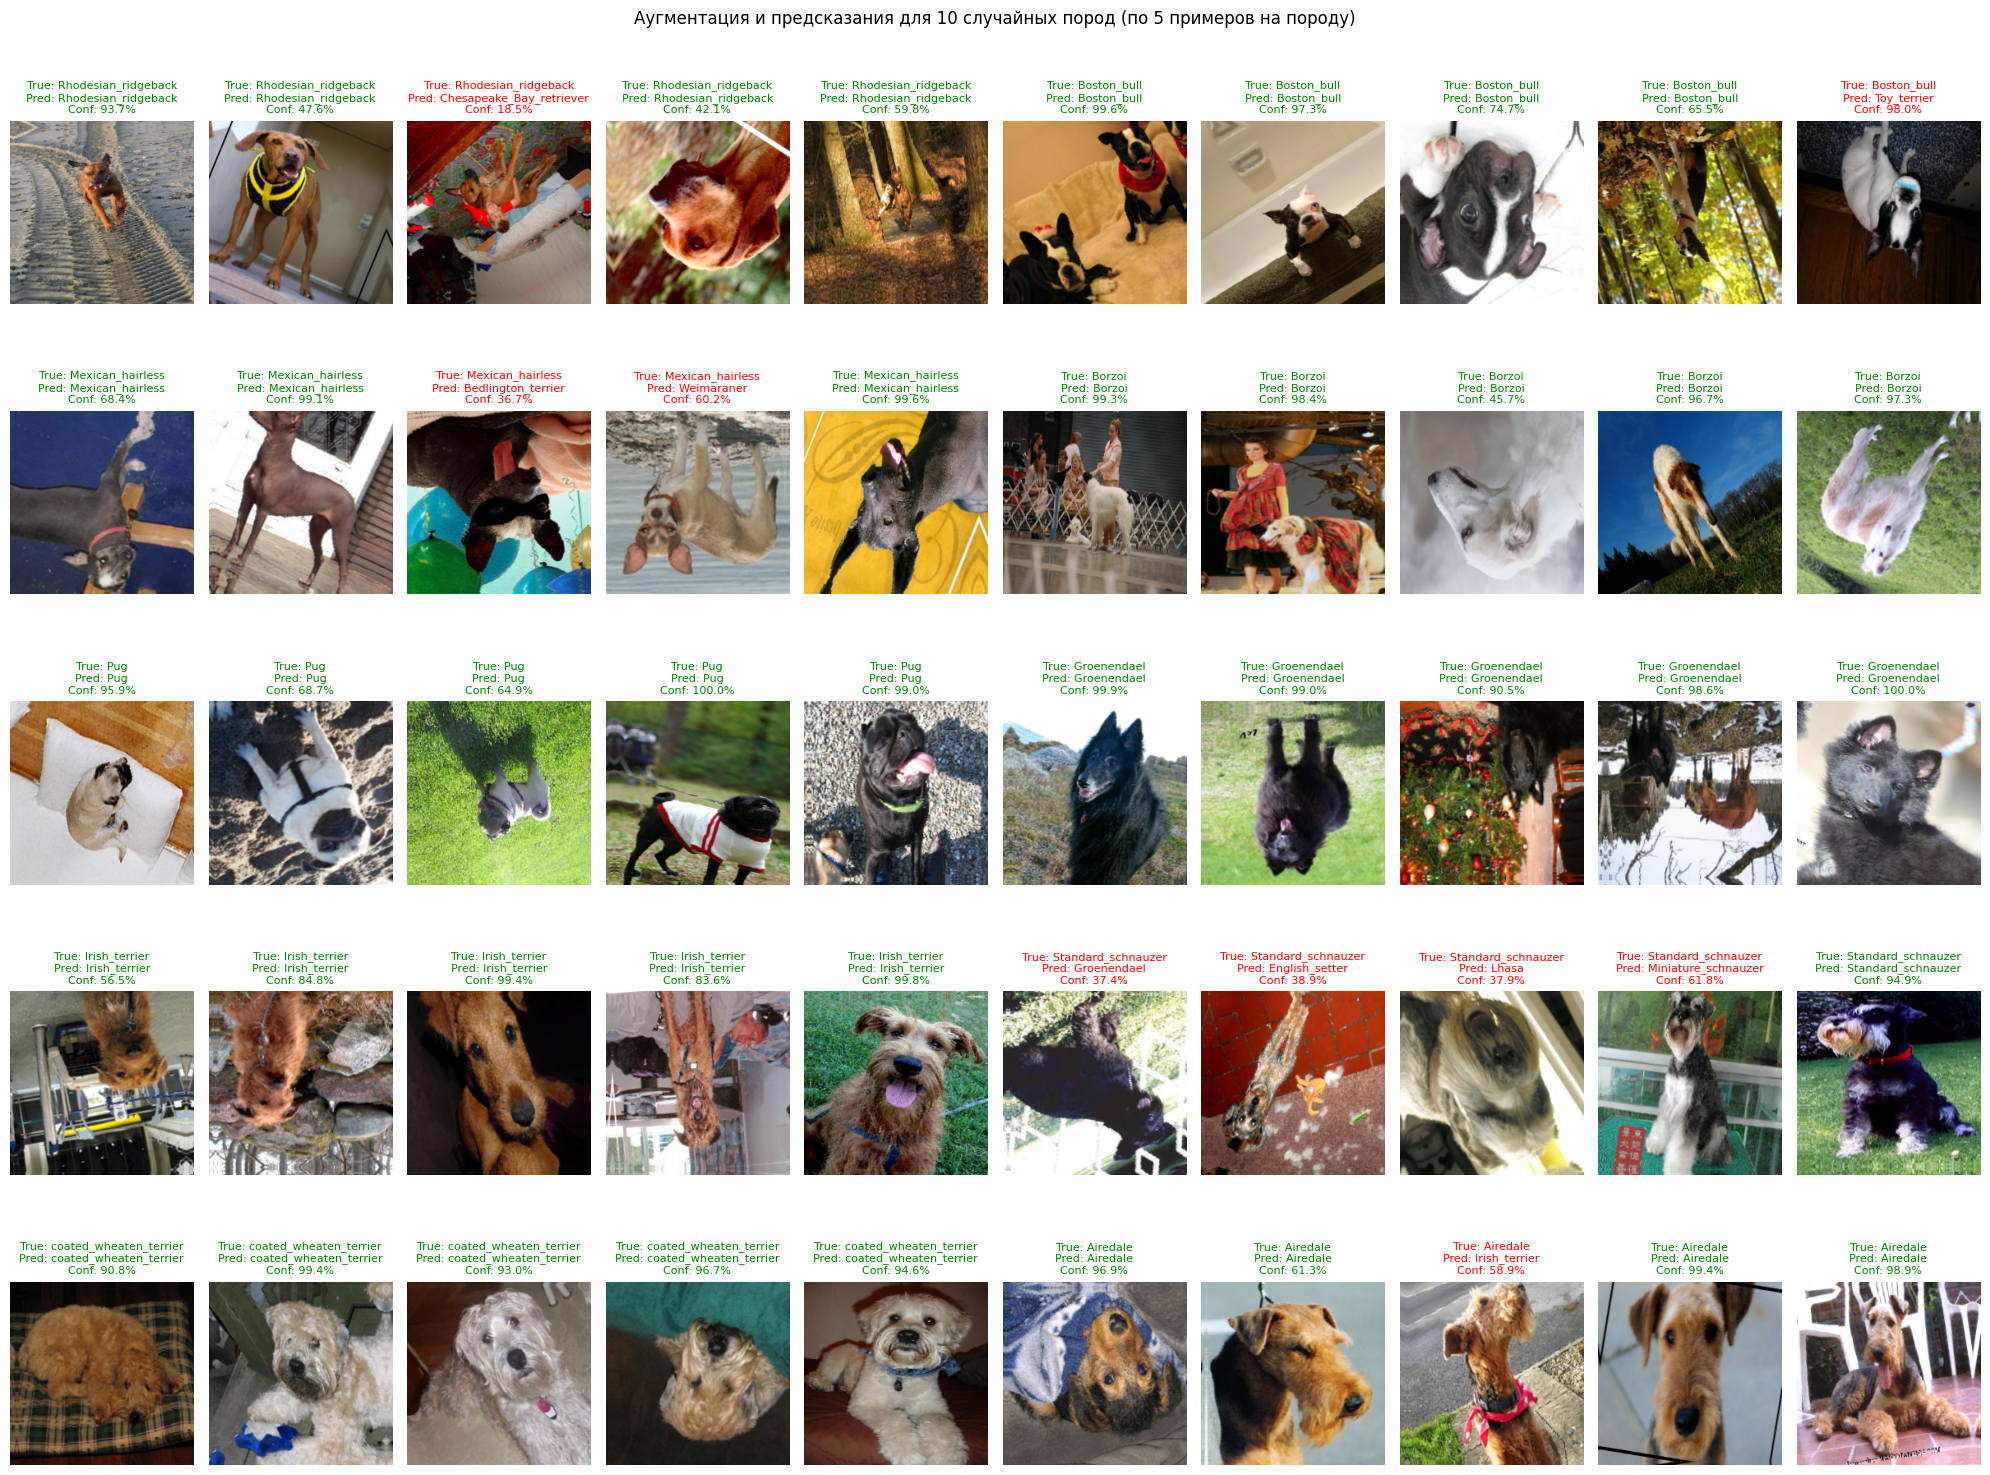

In [ ]:
#выбираем 10 случайных классов (пород собак)
selected_classes = random.sample(CLASS_LIST, 10)
print("Выбранные 10 пород собак:")
for i, breed in enumerate(selected_classes, 1):
    print(f"{i}. {breed.split('-')[-1]}")

#создаем подмножество данных для выбранных классов
selected_images = []
selected_labels = []

for class_name in selected_classes:
    class_path = os.path.join(IMAGE_PATH, class_name)
    image_files = [f for f in os.listdir(class_path) if not f.startswith('.') and os.path.isfile(os.path.join(class_path, f))]

    #берем 5 случайных изображений из каждого класса для демонстрации аугментации
    sample_images = random.sample(image_files, min(5, len(image_files)))

    for image_name in sample_images:
        image_path = os.path.join(class_path, image_name)
        try:
            img = keras.utils.load_img(image_path, target_size=IMAGE_SIZE)
            img_array = keras.utils.img_to_array(img)
            selected_images.append(img_array)
            selected_labels.append(class_name)
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}")
            continue

if not selected_images:
    raise ValueError("Не удалось загрузить изображения")

#применяем аугментацию к выбранным изображениям
augmented_images = []
for img_array in selected_images:
    #добавляем batch dimension (модель ожидает батч изображений)
    img_batch = np.expand_dims(img_array, axis=0)
    #применяем аугментацию
    augmented_img = img_augmentation(img_batch)
    augmented_images.append(augmented_img[0])  #убираем batch dimension

#получаем предсказания модели
images_batch = np.stack(augmented_images)
predictions = model.predict(images_batch)
predicted_classes = [CLASS_LIST[np.argmax(pred)] for pred in predictions]
confidence_scores = [np.max(pred) * 100 for pred in predictions]

#функция для красивого вывода названия породы
def get_breed_name(class_name):
    return class_name.split('-')[-1] if '-' in class_name else class_name

#визуализация результатов
plt.figure(figsize=(20, 15))
for i in range(len(augmented_images)):
    plt.subplot(5, 10, i+1)

    #отображаем аугментированное изображение
    img_to_show = augmented_images[i].numpy() if hasattr(augmented_images[i], 'numpy') else augmented_images[i]
    img_to_show = np.clip(img_to_show, 0, 255).astype('uint8')
    plt.imshow(img_to_show)

    #формируем подпись
    true_name = get_breed_name(selected_labels[i])
    pred_name = get_breed_name(predicted_classes[i])
    confidence = confidence_scores[i]

    title = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1f}%"
    color = 'green' if selected_labels[i] == predicted_classes[i] else 'red'
    plt.title(title, color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Аугментация и предсказания для 10 случайных пород (по 5 примеров на породу)", y=1.02)
plt.show()